In [1]:
import numpy as np
import time

from pdag.data_generator import generate_random_partialB, generate_random_MVN_data
from pdag.pdag import PDAG, _get_partitioned_positions

import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def compute_precision_recall(B, Bhat, threshold=1e-5):
    """
    Compute FP, FN, Precision, and Recall for two matrices.

    Args:
    - B: Ground-truth binary adjacency matrix (NumPy array)
    - Bhat: Predicted adjacency matrix (NumPy array)
    - threshold: Values in Bhat below this are treated as 0 (to avoid numerical noise)

    Returns:
    - FP: False Positives
    - FN: False Negatives
    - Precision: TP / (TP + FP)
    - Recall: TP / (TP + FN)
    """

    # Ensure B and Bhat are binary (1 for edges, 0 for no edges)
    B_bin = (np.abs(B) > threshold).astype(int)  # Convert to 0/1 using threshold
    Bhat_bin = (np.abs(Bhat) > threshold).astype(int)

    # Compute TP, FP, FN
    TP = np.sum((B_bin == 1) & (Bhat_bin == 1))
    FP = np.sum((B_bin == 0) & (Bhat_bin == 1))
    FN = np.sum((B_bin == 1) & (Bhat_bin == 0))

    # Compute Precision and Recall (handle division by zero)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return FP, FN, precision, recall

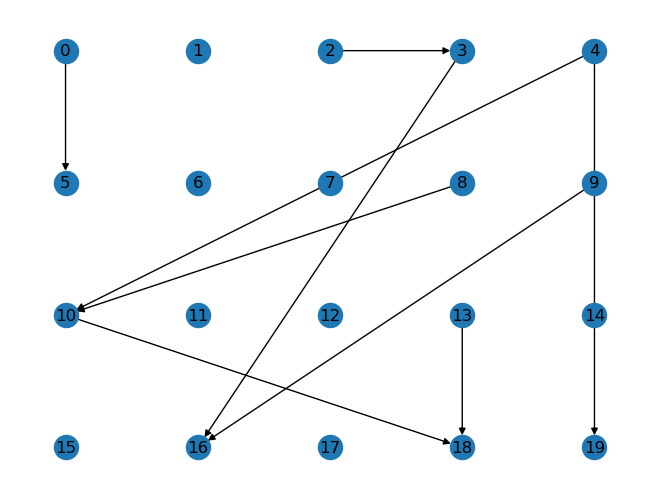

In [3]:
p = 20
n = 10*p
omega, B, A, G = generate_random_partialB(p = p,
                                          partitions=[int(p/4), int(2*p/4), int(3*p/4)],
                                          z=0.05, 
                                          lower_bound=0.1, 
                                          upper_bound=0.9,
                                         )
B = np.array(B)
X = generate_random_MVN_data(n, omega)

pos = _get_partitioned_positions(p, [int(p/4), int(2*p/4), int(3*p/4)])
nx.draw(G, pos=pos, with_labels=True, node_size=300)
plt.show()

In [4]:
pdag = PDAG(
    partitions=[int(p/4), int(2*p/4), int(3*p/4)],  # Pass partitions as a list
    non_active=False,  # Set to True if needed
    complete_data=True,  # Fill missing data
    factor_cols=None,  # Specify categorical variables if necessary
    max_em_iter=50,  # Max iterations for EM algorithm
    em_tol=1e-6,  # Convergence threshold
    robust=True  # Use robust estimation if required
)

# Ensure data is set before fitting
pdag.set_data(X, complete_data=True, factor_cols=None)

# First run to trigger compilation
Bhat = pdag.fit(0.3, [int(p/4), int(2*p/4), int(3*p/4)], max_itr=1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
# Now measure execution time
start = time.time()
Bhat = pdag.fit(0.3, [int(p/4), int(2*p/4), int(3*p/4)], max_itr=100)
end = time.time()

print("Elapsed (after compilation) =", end - start)

Elapsed (after compilation) = 0.002835988998413086


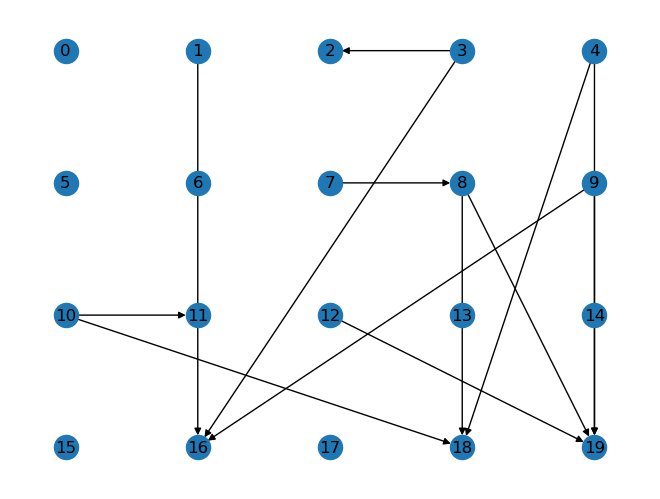

In [10]:
pdag.plotGraph()

In [11]:
FP, FN, precision, recall = compute_precision_recall(B, Bhat)

print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

False Positives (FP): 9
False Negatives (FN): 5
Precision: 0.7273
Recall: 0.8276
